<a href="https://colab.research.google.com/github/JNPauli/Emotional_Machines/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')

In [6]:
y_ = y[0:10000]
y_frames = y[14276:]

In [7]:
y_all = np.concatenate((y_,y_frames))

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [9]:
X = np.load('X_npy.npy')

In [10]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X,y_,test_size=0.2,random_state=42)

In [11]:
del X,y_
gc.collect()

11

In [12]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_,y_train_, test_size = 0.2,random_state=42)

In [13]:
X_frames = np.load('frames_npy.npy')

In [14]:
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_frames,y_frames,test_size=0.2,random_state=42)

In [15]:
del X_frames,y_frames
gc.collect()

11

In [16]:
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_f,y_train_f, test_size = 0.2,random_state=42)

Converting X to appropriate Datatype...

In [17]:
X_tensor_train = torch.from_numpy(X_train_)
del X_train_
gc.collect()
X_tensor_test = torch.from_numpy(X_test_)
del X_test_
gc.collect()
X_tensor_val = torch.from_numpy(X_val_)
del X_val_
gc.collect()

y_tensor_train = torch.from_numpy(y_train_)
del y_train_
gc.collect()
y_tensor_test = torch.from_numpy(y_test_)
del y_test_
gc.collect()
y_tensor_val = torch.from_numpy(y_val_)
del y_val_
gc.collect()

0

In [18]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)
y_tensor_val = y_tensor_val.type(torch.LongTensor)

<ipython-input-18-3ff54277ee2f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-18-3ff54277ee2f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
<ipython-input-18-3ff54277ee2f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)


In [19]:
X_tensor_train_ = torch.from_numpy(X_train_f)
del X_train_f
gc.collect()
X_tensor_test_ = torch.from_numpy(X_test_f)
del X_test_f
gc.collect()
X_tensor_val_ = torch.from_numpy(X_val_f)
del X_val_f
gc.collect()

y_tensor_train_ = torch.from_numpy(y_train_f)
del y_train_f
gc.collect()
y_tensor_test_ = torch.from_numpy(y_test_f)
del y_test_f
gc.collect()
y_tensor_val_ = torch.from_numpy(y_val_f)
del y_val_f
gc.collect()

0

In [20]:
X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)
X_tensor_val = torch.tensor(X_tensor_val_,dtype=torch.float32)

y_tensor_train_ = y_tensor_train_.type(torch.LongTensor)
y_tensor_test_ = y_tensor_test_.type(torch.LongTensor)
y_tensor_val = y_tensor_val_.type(torch.LongTensor)

<ipython-input-20-daeb6c2c99f4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
<ipython-input-20-daeb6c2c99f4>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)
<ipython-input-20-daeb6c2c99f4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_val = torch.tensor(X_tensor_val_,dtype=torch.float32)


In [21]:
X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_),0)
X_tensor_test = torch.cat((X_tensor_test,X_tensor_test_),0)
X_tensor_val = torch.cat((X_tensor_val, X_tensor_val_),0)

y_tensor_train = torch.cat((y_tensor_train,y_tensor_train_),0)
y_tensor_test = torch.cat((y_tensor_test,y_tensor_test_),0)
y_tensor_val = torch.cat((y_tensor_val,y_tensor_val_),0)

In [22]:
X_tensor_train = X_tensor_train.expand(-1, 3, -1, -1)
X_tensor_test = X_tensor_test.expand(-1, 3, -1, -1)
X_tensor_val = X_tensor_val.expand(-1, 3, -1, -1)

In [23]:
print('training shape X is {}, validation shape is {}, test shape X is{}'.format(X_tensor_train.shape,X_tensor_val.shape,X_tensor_test.shape))

training shape X is torch.Size([11102, 3, 224, 224]), validation shape is torch.Size([2352, 3, 224, 224]), test shape X istorch.Size([3470, 3, 224, 224])


To get max value of classN-1

In [24]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1
y_tensor_val = y_tensor_val-1

Setup custom dataset class

In [69]:
train_mean = (0.0505, 0.0505, 0.0505)
train_std = (0.0516, 0.0516, 0.0516)

In [58]:
test_mean = ([0.0510, 0.0510, 0.0510])
test_std = ([0.0520, 0.0520, 0.0520])

In [79]:
val_mean = ([0.0512, 0.0512, 0.0512])
val_std = ([0.0518, 0.0518, 0.0518])

In [74]:
class TrainDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize((0.0505, 0.0505, 0.0505), (0.0516, 0.0516, 0.0516))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [81]:
class TestDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(test_mean, test_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [77]:
class ValDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(val_mean, val_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [82]:
dataset_train = TrainDataset(X_tensor_train,y_tensor_train,transform=True)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = ValDataset(X_tensor_val,y_tensor_val,transform=True)
dataloader_val = DataLoader(dataset_val,batch_size=32)

dataset_test = TestDataset(X_tensor_test,y_tensor_test,transform=True)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


In [53]:
''''
mean_train = 0.
std_train = 0.
nb_samples = 0.
for data,_ in dataloader_val:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean_train += data.mean(2).sum(0)
    std_train += data.std(2).sum(0)
    nb_samples += batch_samples

mean_train /= nb_samples
std_train /= nb_samples

In [ ]:
'''
mean = 0.
std = 0.
for images, _ in dataloader_train:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader_train.dataset)
std /= len(dataloader_train.dataset)


In [ ]:
mean, std

In [ ]:
mean, std

In [ ]:
std

Setting up the CNN.

In [83]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch = nn.BatchNorm2d(32)
        #self.conv2 = nn.Conv2d(32,64,3) #remove layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(394272, 128)
        #self.fc2 = nn.Linear(128,10)
        self.Arousal = nn.Linear(128,10) #3
        self.Valence = nn.Linear(128,10)
        self.Dominance = nn.Linear(128,10)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.fc2(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
#removed

In [ ]:
SalienceNet = CNN()
#SalienceNet.to(device)

In [ ]:
class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()

In [ ]:
cont_loss = ContinuousLoss_L2()

In [84]:
criterion = nn.CrossEntropyLoss()

In [86]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,dataloader_val,
          epoch=10, learning_rate=0.0001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    for param in model_CNN.parameters():
        param.requires_grad = False
    for param in model_CNN.Arousal.parameters():
      param.requires_grad = True
    for param in model_CNN.Valence.parameters():
      param.requires_grad = True
    for param in model_CNN.Dominance.parameters():
      param.requires_grad = True
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_epoch_loss = []
    val_epoch_loss = []
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)
        val_loop = tqdm(dataloader_val)
        total = 0
        correct_a,correct_v,correct_d=0,0,0
        net.to(device)
        net.train()
        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())

            _a, y_pred_train_arousal = torch.max(Arousal,1)
            _v, y_pred_train_valence = torch.max(Valence,1)
            _d, y_pred_train_dominance = torch.max(Dominance,1)

            total += label[:,0].size(0)+label[:,1].size(0)+label[:,2].size(0)

            correct_a += (y_pred_train_arousal == label[:,0]).sum().item()
            correct_v += (y_pred_train_valence == label[:,1]).sum().item()
            correct_d += (y_pred_train_dominance == label[:,2]).sum().item()

            sum_correct = (correct_a+correct_v+correct_d)
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance


            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update

            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")

        train_accuracy.append(sum_correct/total)
        train_epoch_loss.append((np.array(train_loss).mean()))

        #validation
        net.eval()
        val_total = 0
        val_arousal,val_valence, val_dominance = 0,0,0
        for data, labels in dataloader_val:
            data, labels = data.to(device), labels.to(device)

            Arousal_v,Valence_v,Dominance_v = net(data.float())

            _a, y_pred_val_arousal = torch.max(Arousal_v,1)
            _v, y_pred_val_valence = torch.max(Valence_v,1)
            _d, y_pred_val_dominance = torch.max(Dominance_v,1)

            val_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

            val_arousal += (y_pred_val_arousal == labels[:,0]).sum().item()
            val_valence += (y_pred_val_valence == labels[:,1]).sum().item()
            val_dominance += (y_pred_val_dominance == labels[:,2]).sum().item()

            sum_correct_val = (val_arousal+val_valence+val_dominance)

            loss_arousal_v = loss_fn(Arousal_v,labels[:,0])
            loss_valence_v = loss_fn(Valence_v,labels[:,1])
            loss_dominance_v = loss_fn(Dominance_v,labels[:,2])

            val_l=loss_arousal_v+loss_valence_v+loss_dominance_v

            val_loss.append(val_l.item())

        val_epoch_loss.append((np.array(val_loss).mean()))

        val_accuracy.append(sum_correct_val/val_total)


    return train_loss,train_epoch_loss,val_loss,val_epoch_loss, train_accuracy,val_accuracy


In [87]:
def test(net,loss_fn,dataloader_test):
  net.eval()
  test_loss = []
  test_total = 0
  test_arousal,test_valence, test_dominance = 0,0,0

  test_acc = []
  test_loop = tqdm(dataloader_test)
  i=0
  for batch, (data, labels) in enumerate(test_loop):
      print('testing...')

      data, labels = data.to(device), labels.to(device)
      arousal,valence,dominance = net(data.float())

      __a, y_pred_test_arousal = torch.max(arousal,1)
      __v, y_pred_test_valence = torch.max(valence,1)
      __d, y_pred_test_dominance = torch.max(dominance,1)

      arousal_t = loss_fn(arousal,labels[:,0])
      valence_t = loss_fn(valence,labels[:,1])
      dominance_t = loss_fn(dominance,labels[:,2])

      test_l = arousal_t+valence_t+dominance_t

      test_loss.append(test_l.item())
      test_loop.set_description(f"Batch [{i+1}/{batch}]")
      i=+1

      test_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

      test_arousal += (y_pred_test_arousal == labels[:,0]).sum().item()
      test_valence += (y_pred_test_valence == labels[:,1]).sum().item()
      test_dominance += (y_pred_test_dominance == labels[:,2]).sum().item()

      sum_correct_test = (test_arousal+test_valence+test_dominance)
      #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()

      test_acc.append(sum_correct_test/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc)
  return test_loss, test_acc

In [88]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [89]:
import matplotlib.pyplot as plt

In [90]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [91]:
from torchvision import models

In [92]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 54.7MB/s]


In [93]:
class CNN1(nn.Module):
    def __init__(self, pretrained):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = models.__dict__["alexnet"](pretrained="imagenet")
        else:
            self.model = models.__dict__["alexnet"](pretrained=None)
        self.Arousal= nn.Linear(256, 10)
        self.Valence = nn.Linear(256,10)
        self.Dominance = nn.Linear(256, 10)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
        return {'label1': label1, 'label2': label2, 'label3': label3}

In [94]:
model_CNN = CNN1(True).to(device)

In [95]:
for param in model_CNN.parameters():
        param.requires_grad = False
for param in model_CNN.Arousal.parameters():
  param.requires_grad = True
for param in model_CNN.Valence.parameters():
  param.requires_grad = True
for param in model_CNN.Dominance.parameters():
  param.requires_grad = True

In [99]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,val_loss,val_epoch_loss,train_acc,val_acc=train(net=model_CNN,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_val=dataloader_val,epoch=20,learning_rate=0.001)




  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/74 [00:15<?, ?it/s]


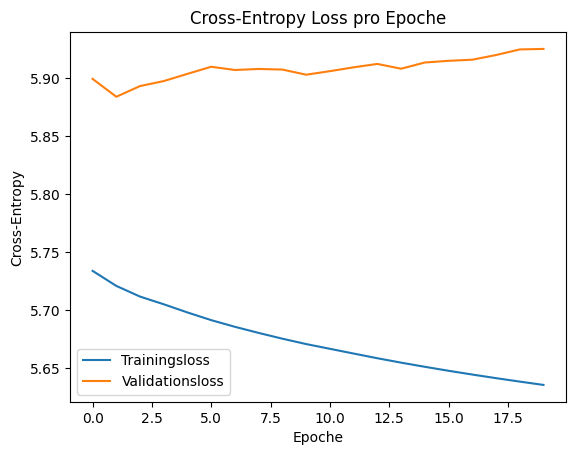

In [100]:
plt.plot(train_epoch_loss, label = 'Trainingsloss')
plt.plot(val_epoch_loss, label = 'Validationsloss')
plt.xlabel('Epoche')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss pro Epoche')
plt.legend()
plt.show()

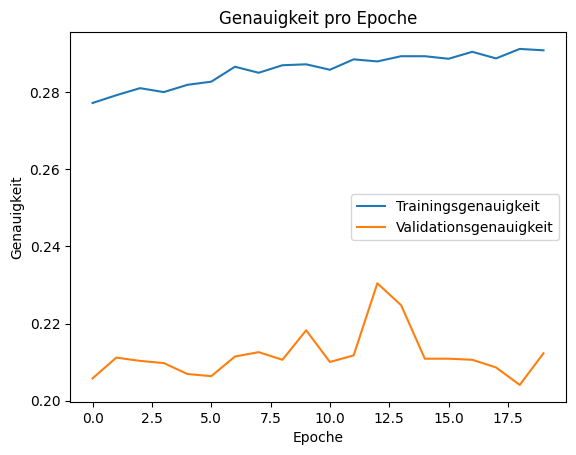

In [101]:
plt.plot(train_acc, label = 'Trainingsgenauigkeit')
plt.plot(val_acc, label = 'Validationsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit pro Epoche')
plt.legend()
plt.show()

In [ ]:
test_loss,test_acc = test(net=model_CNN,loss_fn=criterion,dataloader_test=dataloader_test)

In [ ]:
plt.plot(test_loss)
plt.xlabel('Loss pro Batch-Einheit')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss für die Testdaten')
plt.show()

In [ ]:
plt.plot(test_acc)
plt.xlabel('Genauigkeit pro Batch-Einheit')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit für die Testdaten')
plt.show()

In [ ]:
np.mean(test_acc), np.std(test_acc)

In [ ]:
np.mean(train_acc), np.mean(val_acc), np.std(train_acc),np.std(val_acc)